In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn import  linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.model_selection import GridSearchCV
import math as ma
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import autograd.numpy as np

# To do elementwise differentiation:
from autograd import elementwise_grad as egrad 
from autograd import grad

In [2]:
class NN:
    
    def __init__(self,
                 X_train,
                 X_test,
                 z_train,
                 z_test,
                 n_hidden_layers,
                 n_hidden_neurons,
                 act_function,
                 n_outputs,
                 innit,
                 classify,
                 out_func):

        self.X_train = X_train
        self.X_test = X_test
        self.z_train = z_train
        self.z_test = z_test
        
        
        if len(X_train.shape) > 1:
            self.n_inputs, self.n_features = self.X_train.shape
        if len(X_train.shape) == 1:   
            self.n_inputs = len(X_train)
            self.n_features = 1
        
        self.n_outputs = n_outputs  
        self.n_hidden_layers = n_hidden_layers
        self.n_hidden_neurons = n_hidden_neurons
        
        
        self.weights = self.weight_create(innit)
        self.biases = self.bias_create()
        self.classify = classify
        
        if classify == 1:
            
            if (out_func == "tanh"):
                self.out_func = self.tanh
                self.check = "tan"
            elif(out_func == "Sigmoid"):
                self.out_func = self.sigmoid
                self.check = "sig"
            else:
                print("Choose tanh or Sigmoid")

        
        if(act_function == "Sigmoid"):
            self.act_function= self.sigmoid
            self.d_act  = self.d_sigmoid
        elif(act_function  == "RELU"):
            self.act_function = self.relu
            self.d_act = self.d_relu
        elif(act_function  == "LRELU"):
            self.act_function= self.lrelu
            self.d_act  = self.d_lrelu
        elif(act_function  == "tanh"):
            self.act_function = self.tanh
            self.d_act  = self.d_tanh
        else:
            print("please choose ,Sigmoid,RELU,LRELU or tanh")
            quit()

    def weight_create(self,innit):  # initilazing weights. all at random between 0 and 1
        weights = []
        if (innit == "explode-gradient"):
            
            In_weights = np.random.randn(self.n_features, self.n_hidden_neurons)
            weights.append(In_weights)
            #Weights between hidden layers
            for i in range(1, self.n_hidden_layers):
                weights.append(np.random.randn(self.n_hidden_neurons, self.n_hidden_neurons) )
            # weights out of last activation function   
            Out_weights = np.random.randn(self.n_hidden_neurons, self.n_outputs) 
            weights.append(Out_weights) 
            return weights
        elif (innit == "Xavier"):
            In_weights = np.random.normal(0, np.sqrt(1.0/self.n_features), (self.n_features, self.n_hidden_neurons))
            weights.append(In_weights)
            for i in range(1, self.n_hidden_layers):
                weights.append(np.random.normal(0, np.sqrt(1.0/self.n_hidden_neurons), (self.n_hidden_neurons, self.n_hidden_neurons)))
            Out_weights = np.random.normal(0, np.sqrt(1.0/self.n_hidden_neurons), (self.n_hidden_neurons, self.n_outputs))
            weights.append(Out_weights)
            return weights
        elif(innit == "He"):
            In_weights = np.random.normal(0, np.sqrt(2.0/self.n_features), (self.n_features, self.n_hidden_neurons))
            weights.append(In_weights) #First weights
            for i in range(1, self.n_hidden_layers):
                weights.append(np.random.normal(0, np.sqrt(2.0/self.n_hidden_neurons), (self.n_hidden_neurons, self.n_hidden_neurons)))
            Out_weights = np.random.normal(0, np.sqrt(1.0/self.n_hidden_neurons), (self.n_hidden_neurons, self.n_outputs))
            weights.append(Out_weights) #last weights
            return weights
        else:
            return print("not a valid weight initilization")

    def bias_create(self):  # Starting biases all at zero
        biases = []
        #biases for all hidden layers and first hidden layer
        for i in range(0, self.n_hidden_layers):
            biases.append(np.zeros(self.n_hidden_neurons))
        #Biases for output nodes
        O_b = np.zeros(self.n_outputs)
        biases.append(O_b)
        return biases

    def sigmoid(self, x):  # Active function + derivative
        return 1.0/(1.0 + np.exp(-x))
    def d_sigmoid(self,x):
        return self.sigmoid(x)*(1.0-self.sigmoid(x))

    def relu(self, x): # Active function + derivative
        return x * (x > 0)
       
            
          
    def d_relu(self,x):
        return 1.0 * (x > 0)
        
        

    def lrelu(self, x):# Active function + derivative
        alpha = 0.01
        y1 = ((x >= 0) * x)
        y2 = ((x < 0) * x * alpha)
        y = y1 + y2
        return y
    def d_lrelu(self, x):
        alpha = 0.01
        dy1 =((x >= 0) * 1.0)
        dy2 = ((x < 0) * alpha)
        dy = dy1 + dy2
        return dy

    def tanh (self,x): # Active function + derivative
        return np.tanh(x)
    def d_tanh(self,x):
        y = np.tanh(x)
        dy = 1 - y**2
        return dy


    def mini_batch_creator(self,X, y, batch_size):
        mini_batches = [] # empty list for the mini batchess
        if self.n_features == 1:
            data_matrix = np.hstack((X.reshape(-1, 1), y.reshape(-1, 1)))  # Column 0 to n-1 is data, column n is the target data
        if self.n_features != 1:
            data_matrix = np.hstack((X, y.reshape(-1, 1)))  # Column 0 to n-1 is data, column n is the target data
            
        

        np.random.shuffle(data_matrix) # would not be stochastic if it didnt include random. 

        m = data_matrix.shape[0] // batch_size # number of minibatches number of rows/datapoints divided by selected batchsize
        i=0
        for i in range(m):
            mini_batch = data_matrix[i * batch_size:(i + 1)*batch_size, :]#creating a mini batch
            X_mini = mini_batch[:, :-1] #evry thing except the last column
            Y_mini = mini_batch[:, -1] #exclusively the last column
            mini_batches.append((X_mini, Y_mini)) # has 2 arrays, first array contains the minibatches for x and the second for y
        if data_matrix.shape[0] % batch_size != 0:
            mini_batch = data_matrix[i * batch_size:data_matrix.shape[0]]
            X_mini = mini_batch[:, :-1]
            Y_mini = mini_batch[:, -1]
            mini_batches.append((X_mini, Y_mini))
        return mini_batches

    def FFD_train(self):
        self.act_list = []
        self.values = []
        z_hidden = np.matmul(self.X_mini_i, self.weights[0]) + self.biases[0]
        self.values.append(z_hidden)
        a_hidden = self.act_function(z_hidden)
        self.act_list.append(a_hidden)
        for layer_i in range(1, self.n_hidden_layers):
            z_hidden = np.matmul(a_hidden, self.weights[layer_i]) + self.biases[layer_i]
            self.values.append(z_hidden)
            a_hidden = self.act_function(z_hidden)
            
            self.act_list.append(a_hidden)
        #Output values
        z_out = np.matmul(a_hidden, self.weights[-1]) + self.biases[-1]
        self.values.append(z_out)
        a_out = z_out
        if self.classify == 1:
            a_out = self.out_func(z_out)
            
        self.act_list.append(a_out)
        return 
    
    def FFD_predict(self, X):  # feed forward pass for test set
        z_hidden = np.matmul(X, self.weights[0]) + self.biases[0]
        a_hidden = self.act_function(z_hidden)
        for layer_i in range(1, self.n_hidden_layers):
            z_hidden = np.matmul(a_hidden, self.weights[layer_i]) + self.biases[layer_i]
            a_hidden = self.act_function(z_hidden)
        z_out = np.matmul(a_hidden, self.weights[-1]) + self.biases[-1]
        if self.classify == 1:
            z_out = self.out_func(z_out)
        nan_check = np.isnan(z_out).any()
        if nan_check == True:
            print("Exploding/vanishing gradient encounterd")
            z_out = np.zeros(z_out.shape)
        return z_out
            
            
        
        
    def back_prop(self):
        #gradient descent solver algorithm 
        # Step Size = delta_l from nielsens book
        def GD_solver(step_size,layer_i):
            if (layer_i == 0):
                gradient_weigths_in = np.matmul(self.X_mini_i.T, step_size)
                gradient_biases_in = np.sum(step_size, axis=0)
                if (self.lmb > 0.0):
                    gradient_weigths_in += self.lmb * self.weights[layer_i]
                self.weights[layer_i] = self.weights[layer_i] - self.eta * gradient_weigths_in
                self.biases[layer_i] = self.biases[layer_i] - self.eta * gradient_biases_in
            else:
                gradient_weigths_hidden = np.matmul(self.act_list[layer_i-1].T, step_size)
                #print(gradient_weigths)
                gradient_biases_hidden = np.sum(step_size, axis=0)
                if (self.lmb > 0.0):
                    gradient_weigths_hidden += self.lmb * self.weights[layer_i]
                self.weights[layer_i] = self.weights[layer_i] - self.eta * gradient_weigths_hidden
                self.biases[layer_i] = self.biases[layer_i] - self.eta * gradient_biases_hidden
            return
        #Final/ gradient step
        step_size = self.act_list[-1] - self.Y_mini_i
        GD_solver(step_size,-1)
        
        
        #start from the last bias and weights toward the input nodes -1 
        for layer_i in range(self.n_hidden_layers-1, 0, -1):
            step_size =  np.matmul(step_size, self.weights[layer_i+1].T) * self.d_act(self.values[layer_i]) # Chain rule 
            GD_solver(step_size,layer_i) #  utelizing the GD to solve for optimal
            
        #First gradient step 
        step_size_0 = np.matmul(step_size, self.weights[1].T) * self.d_act(self.values[0]) # chain rule
        GD_solver(step_size_0,0)
        
        return




    def train_nn(self,n_epochs,batch_size,eta = 0.1,lmb = 0):
        self.eta = eta
        self.lmb = lmb
        for epoch in range(n_epochs):
            mini_batches = self.mini_batch_creator(self.X_train,self.z_train,batch_size)
            for batch in mini_batches:
                self.X_mini_i,self.Y_mini_i = batch
                self.Y_mini_i = self.Y_mini_i.reshape(-1,1) # Column vector
                self.FFD_train()
                self.back_prop()
    
    
    def predict (self,X):
        z = self.FFD_predict(X)
        if self.classify == 1:
            if self.check == "sig":
                
                for i in range(len(z)):
                    if z[i] < 0.5:
                        z[i] = int(0)
                    elif z[i] >= 0.5:
                        z[i] = int(1)
                return z.ravel()
            elif self.check == "tan":
                
                for i in range(len(z)):
                    if z[i] < 0.0:
                        z[i] = int(-1)
                    elif z[i] >= 0.0:
                        z[i] = int(1)
                return z.ravel()
                
        else:
            return z







    
    
    
    
    

# Set up data

In [3]:
from sklearn.datasets import load_breast_cancer

In [7]:
# Taking in the PCA that Was created for breast cancer

df_PCA_cancer = pd.read_csv("Breast_cancer_PCA")

X =  df_PCA_cancer.to_numpy()

X.shape

(569, 3)

In [8]:
np.random.seed(644)
BC = load_breast_cancer()


z = BC.target.copy()

X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
np.random.seed(644)
BC = load_breast_cancer()
A = X
t = BC.target.copy()

t[t==0] = -1

A_train, A_test, t_train, t_test = train_test_split(A,t, test_size=0.2)

scaler = StandardScaler()
A_train = scaler.fit_transform(A_train)
A_test = scaler.transform(A_test)

# Setting up neural network for the different parameters to be analyzed

First i want to tune lambda and eta. For all the functions. 

# setting up the framework for tuning lambda and eta

In [10]:
#initial values for the parameters
n_epochs = 100
n_layers = 2 # chosen for the analysis
n_neurons = 35 # chosen for the analysis
n_outputs = 1 # chosen for the analysis binary classification case
batch_size = 20

#activation functions
act_1 = "Sigmoid"
act_2 = "tanh"
act_3 = "RELU"
act_4 = "LRELU"

#weight initilisation
innit_1 = "Xavier"
innit_2 = "He"

#classification parameters
cls = 1 # 1 for classification case
#Output functions
out_func = "Sigmoid"
out_func_2 = "tanh"
etas = np.logspace(-8,-2,5)
lambdas = np.logspace(-7,-1,7)

#NN_activationfuncton_weightinitilization_outputfunction

#Sigmoid combinations
NN_sig_xav_sig = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_1,n_outputs,innit_1,cls,out_func)
NN_sig_he_sig = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_1,n_outputs,innit_2,cls,out_func)
NN_sig_xav_tanh = NN(A_train,A_test,t_train,t_test,n_layers,n_neurons,act_1,n_outputs,innit_1,cls,out_func_2)
NN_sig_he_tanh = NN(A_train,A_test,t_train,t_test,n_layers,n_neurons,act_1,n_outputs,innit_2,cls,out_func_2)
#tanh activation function combinations
NN_tanh_xav_sig = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_2,n_outputs,innit_1,cls,out_func)
NN_tanh_he_sig = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_2,n_outputs,innit_2,cls,out_func)
NN_tanh_xav_tanh = NN(A_train,A_test,t_train,t_test,n_layers,n_neurons,act_2,n_outputs,innit_1,cls,out_func_2)
NN_tanh_he_tanh = NN(A_train,A_test,t_train,t_test,n_layers,n_neurons,act_2,n_outputs,innit_2,cls,out_func_2)
#Relu activation function combinations
NN_Rel_xav_sig = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_3,n_outputs,innit_1,cls,out_func)
NN_Rel_he_sig = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_3,n_outputs,innit_2,cls,out_func)
NN_Rel_xav_tanh = NN(A_train,A_test,t_train,t_test,n_layers,n_neurons,act_3,n_outputs,innit_1,cls,out_func_2)
NN_Rel_he_tanh = NN(A_train,A_test,t_train,t_test,n_layers,n_neurons,act_3,n_outputs,innit_2,cls,out_func_2)
#Leaky Relu activation function combinations
NN_LRel_xav_sig = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_4,n_outputs,innit_1,cls,out_func)
NN_LRel_he_sig = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_4,n_outputs,innit_2,cls,out_func)
NN_LRel_xav_tanh = NN(A_train,A_test,t_train,t_test,n_layers,n_neurons,act_4,n_outputs,innit_1,cls,out_func_2)
NN_LRel_he_tanh = NN(A_train,A_test,t_train,t_test,n_layers,n_neurons,act_4,n_outputs,innit_2,cls,out_func_2)




# Setting up the different Networks for grid searching lambda and eta

In [11]:
#Sigmoid cost scores
acc_sig_xav_sig = np.zeros((len(lambdas),len(etas)))
acc_sig_xav_tanh = np.zeros((len(lambdas),len(etas)))
acc_sig_he_sig = np.zeros((len(lambdas),len(etas)))
acc_sig_he_tanh = np.zeros((len(lambdas),len(etas)))

# tanh cost scores
acc_tanh_xav_sig = np.zeros((len(lambdas),len(etas)))
acc_tanh_xav_tanh = np.zeros((len(lambdas),len(etas)))
acc_tanh_he_sig = np.zeros((len(lambdas),len(etas)))
acc_tanh_he_tanh= np.zeros((len(lambdas),len(etas)))

# Relu cost scores
acc_Rel_xav_sig = np.zeros((len(lambdas),len(etas)))
acc_Rel_xav_tanh = np.zeros((len(lambdas),len(etas)))
acc_Rel_he_sig = np.zeros((len(lambdas),len(etas)))
acc_Rel_he_tanh = np.zeros((len(lambdas),len(etas)))

#Leaky Relu cost scores
acc_LRel_xav_sig = np.zeros((len(lambdas),len(etas)))
acc_LRel_xav_tanh = np.zeros((len(lambdas),len(etas)))
acc_LRel_he_sig = np.zeros((len(lambdas),len(etas)))
acc_LRel_he_tanh = np.zeros((len(lambdas),len(etas)))





In [12]:
#Using sickit learns acuracy score, Check NN.ipyn for comparing own accuracy score with sickits
from sklearn.metrics import accuracy_score



# Sigmoid run

In [13]:
np.random.seed(653)
for i in range(len(lambdas)):
    lmb = lambdas[i]
    for j in range(len(etas)):
        #resetting neural network for each itteration
        NN_sig_xav_sig = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_1,n_outputs,innit_1,cls,out_func)
        NN_sig_he_sig = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_1,n_outputs,innit_2,cls,out_func)
        NN_sig_xav_tanh = NN(A_train,A_test,t_train,t_test,n_layers,n_neurons,act_1,n_outputs,innit_1,cls,out_func_2)
        NN_sig_he_tanh = NN(A_train,A_test,t_train,t_test,n_layers,n_neurons,act_1,n_outputs,innit_2,cls,out_func_2) # resett the neural network
        eta = etas[j]
        #training nerual network
        NN_sig_xav_sig.train_nn(n_epochs,batch_size,eta,lmb)
        NN_sig_he_sig.train_nn(n_epochs,batch_size,eta,lmb)
        NN_sig_xav_tanh.train_nn(n_epochs,batch_size,eta,lmb)
        NN_sig_he_tanh.train_nn(n_epochs,batch_size,eta,lmb)
        
        #Predictions
        z_pred_xav_sig = NN_sig_xav_sig.predict(X_test)
        z_pred_he_sig = NN_sig_he_sig.predict(X_test)
        z_pred_xav_tanh = NN_sig_xav_tanh.predict(A_test)
        z_pred_he_tanh = NN_sig_he_tanh.predict(A_test)
        
        #accuracy scores
        acc_sig_he_sig[i,j] = accuracy_score(z_test,z_pred_he_sig)
        acc_sig_xav_sig[i,j] = accuracy_score(z_test,z_pred_xav_sig)
        
        acc_sig_xav_tanh[i,j] = accuracy_score(t_test,z_pred_xav_tanh)
        acc_sig_he_tanh[i,j] = accuracy_score(t_test,z_pred_he_tanh)
        
        
df_grid_sig_xav_sig = pd.DataFrame(acc_sig_xav_sig, index = lambdas, columns = etas)
df_grid_sig_xav_tanh = pd.DataFrame(acc_sig_xav_tanh, index = lambdas, columns = etas)
df_grid_sig_he_sig = pd.DataFrame(acc_sig_he_sig, index = lambdas, columns = etas)
df_grid_sig_he_tanh = pd.DataFrame(acc_sig_he_tanh, index = lambdas, columns = etas)

In [14]:
df_grid_sig_xav_sig.max()

1.000000e-08    0.543860
3.162278e-07    0.543860
1.000000e-05    0.543860
3.162278e-04    0.728070
1.000000e-02    0.938596
dtype: float64

In [15]:
df_grid_sig_xav_sig.stack().index[np.argmax(df_grid_sig_xav_sig.values)] #(labda,eta)

(1e-06, 0.01)

In [16]:
df_grid_sig_he_sig.max()

1.000000e-08    0.552632
3.162278e-07    0.543860
1.000000e-05    0.543860
3.162278e-04    0.912281
1.000000e-02    0.938596
dtype: float64

In [17]:
df_grid_sig_he_sig.stack().index[np.argmax(df_grid_sig_he_sig.values)] #(labda,eta)

(1e-07, 0.01)

Best Eta and lambda sigmoid in outputlayer

In [18]:
lmb_sig_xav_sig = df_grid_sig_xav_sig.stack().index[np.argmax(df_grid_sig_xav_sig.values)][0] 
lmb_sig_he_sig = df_grid_sig_he_sig.stack().index[np.argmax(df_grid_sig_he_sig.values)][0]


eta_sig_xav_sig = df_grid_sig_xav_sig.stack().index[np.argmax(df_grid_sig_xav_sig.values)][1] 
eta_sig_he_sig = df_grid_sig_he_sig.stack().index[np.argmax(df_grid_sig_he_sig.values)][1]


In [19]:
df_grid_sig_xav_tanh.max()

1.000000e-08    0.543860
3.162278e-07    0.543860
1.000000e-05    0.543860
3.162278e-04    0.921053
1.000000e-02    0.938596
dtype: float64

In [20]:
df_grid_sig_xav_tanh.stack().index[np.argmax(df_grid_sig_xav_tanh.values)] #(labda,eta)

(1e-07, 0.01)

In [21]:
df_grid_sig_he_tanh.max()

1.000000e-08    0.543860
3.162278e-07    0.701754
1.000000e-05    0.543860
3.162278e-04    0.921053
1.000000e-02    0.929825
dtype: float64

In [22]:
df_grid_sig_he_tanh.stack().index[np.argmax(df_grid_sig_he_tanh.values)] #(labda,eta)

(1e-07, 0.01)

Best Eta and lambda tanh in outputlayer

In [23]:
lmb_sig_xav_tanh = df_grid_sig_xav_tanh.stack().index[np.argmax(df_grid_sig_xav_tanh.values)][0]
lmb_sig_he_tanh = df_grid_sig_he_tanh.stack().index[np.argmax(df_grid_sig_he_tanh.values)][0]

eta_sig_xav_tanh = df_grid_sig_xav_tanh.stack().index[np.argmax(df_grid_sig_xav_tanh.values)][1]
eta_sig_he_tanh = df_grid_sig_he_tanh.stack().index[np.argmax(df_grid_sig_he_tanh.values)][1]

For sigmoid activation , He initiation and sigmoid output function yields best result acc =0.95

# Tuning Tanh lambda and eta

In [24]:
np.random.seed(653)
for i in range(len(lambdas)):
    lmb = lambdas[i]
    for j in range(len(etas)):
        NN_tanh_xav_sig = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_2,n_outputs,innit_1,cls,out_func)
        NN_tanh_he_sig = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_2,n_outputs,innit_2,cls,out_func)
        NN_tanh_xav_tanh = NN(A_train,A_test,t_train,t_test,n_layers,n_neurons,act_2,n_outputs,innit_1,cls,out_func_2)
        NN_tanh_he_tanh = NN(A_train,A_test,t_train,t_test,n_layers,n_neurons,act_2,n_outputs,innit_2,cls,out_func_2)
        eta = etas[j]
        
        #training nerual network
        NN_tanh_xav_sig.train_nn(n_epochs,batch_size,eta,lmb)
        NN_tanh_he_sig.train_nn(n_epochs,batch_size,eta,lmb)
        NN_tanh_xav_tanh.train_nn(n_epochs,batch_size,eta,lmb)
        NN_tanh_he_tanh.train_nn(n_epochs,batch_size,eta,lmb)
        
        #Predictions
        z_pred_xav_sig = NN_tanh_xav_sig.predict(X_test)
        z_pred_he_sig = NN_tanh_he_sig.predict(X_test)
        z_pred_xav_tanh = NN_tanh_xav_tanh.predict(A_test)
        z_pred_he_tanh = NN_tanh_he_tanh.predict(A_test)
        
        #accuracy scores
        acc_tanh_he_sig[i,j] = accuracy_score(z_test,z_pred_he_sig)
        acc_tanh_xav_sig[i,j] = accuracy_score(z_test,z_pred_xav_sig)
        
        acc_tanh_xav_tanh[i,j] = accuracy_score(t_test,z_pred_xav_tanh)
        acc_tanh_he_tanh[i,j] = accuracy_score(t_test,z_pred_he_tanh)
        
        
df_grid_tanh_xav_sig = pd.DataFrame(acc_tanh_xav_sig, index = lambdas, columns = etas)
df_grid_tanh_xav_tanh = pd.DataFrame(acc_tanh_xav_tanh, index = lambdas, columns = etas)
df_grid_tanh_he_sig = pd.DataFrame(acc_tanh_he_sig, index = lambdas, columns = etas)
df_grid_tanh_he_tanh = pd.DataFrame(acc_tanh_he_tanh, index = lambdas, columns = etas)

In [25]:
df_grid_tanh_xav_sig.max()

1.000000e-08    0.754386
3.162278e-07    0.885965
1.000000e-05    0.947368
3.162278e-04    0.938596
1.000000e-02    0.929825
dtype: float64

In [26]:

df_grid_tanh_xav_sig.stack().index[np.argmax(df_grid_tanh_xav_sig.values)] #(labda,eta)

(1e-06, 1e-05)

In [27]:

df_grid_tanh_he_sig .max()

1.000000e-08    0.877193
3.162278e-07    0.807018
1.000000e-05    0.964912
3.162278e-04    0.938596
1.000000e-02    0.938596
dtype: float64

In [28]:

df_grid_tanh_he_sig.stack().index[np.argmax(df_grid_tanh_he_sig.values)] #(labda,eta)

(0.001, 1e-05)

In [29]:
lmb_tanh_xav_sig = df_grid_tanh_xav_sig.stack().index[np.argmax(df_grid_tanh_xav_sig.values)][0]
lmb_tanh_he_sig = df_grid_tanh_he_sig.stack().index[np.argmax(df_grid_tanh_he_sig.values)][0]


eta_tanh_xav_sig = df_grid_tanh_xav_sig.stack().index[np.argmax(df_grid_tanh_xav_sig.values)][1]
eta_tanh_he_sig = df_grid_tanh_he_sig.stack().index[np.argmax(df_grid_tanh_he_sig.values)][1]


In [30]:

df_grid_tanh_xav_tanh.max()

1.000000e-08    0.807018
3.162278e-07    0.675439
1.000000e-05    0.947368
3.162278e-04    0.947368
1.000000e-02    0.938596
dtype: float64

In [31]:

df_grid_tanh_xav_tanh.stack().index[np.argmax(df_grid_tanh_xav_tanh.values)] #(labda,eta)
#np.argmax(df_grid_tanh_xav_tanh.values)

(1e-05, 1e-05)

In [32]:

df_grid_tanh_he_tanh.max() #best accurucy of each column

1.000000e-08    0.508772
3.162278e-07    0.754386
1.000000e-05    0.947368
3.162278e-04    0.938596
1.000000e-02    0.938596
dtype: float64

In [33]:

df_grid_tanh_he_tanh.stack().index[np.argmax(df_grid_tanh_he_tanh.values)] #(labda,eta)

(0.1, 1e-05)

In [34]:
lmb_tanh_xav_tanh = df_grid_tanh_xav_tanh.stack().index[np.argmax(df_grid_tanh_xav_tanh.values)][0]
lmb_tanh_he_tanh = df_grid_tanh_he_tanh.stack().index[np.argmax(df_grid_tanh_he_tanh.values)][0]

eta_tanh_xav_tanh = df_grid_tanh_xav_tanh.stack().index[np.argmax(df_grid_tanh_xav_tanh.values)][1]
eta_tanh_he_tanh = df_grid_tanh_he_tanh.stack().index[np.argmax(df_grid_tanh_he_tanh.values)][1]

# Relu Tuning


In [35]:
np.random.seed(653)
for i in range(len(lambdas)):
    lmb = lambdas[i]
    for j in range(len(etas)):
        NN_Rel_xav_sig = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_3,n_outputs,innit_1,cls,out_func)
        NN_Rel_he_sig = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_3,n_outputs,innit_2,cls,out_func)
        NN_Rel_xav_tanh = NN(A_train,A_test,t_train,t_test,n_layers,n_neurons,act_3,n_outputs,innit_1,cls,out_func_2)
        NN_Rel_he_tanh = NN(A_train,A_test,t_train,t_test,n_layers,n_neurons,act_3,n_outputs,innit_2,cls,out_func_2)
        eta = etas[j]
        
        NN_Rel_xav_sig.train_nn(n_epochs,batch_size,eta,lmb)
        NN_Rel_he_sig.train_nn(n_epochs,batch_size,eta,lmb)
        NN_Rel_xav_tanh.train_nn(n_epochs,batch_size,eta,lmb)
        NN_Rel_he_tanh.train_nn(n_epochs,batch_size,eta,lmb)
        
        #Predictions
        z_pred_xav_sig = NN_Rel_xav_sig.predict(X_test)
        z_pred_he_sig = NN_Rel_he_sig.predict(X_test)
        z_pred_xav_tanh = NN_Rel_xav_tanh.predict(A_test)
        z_pred_he_tanh = NN_Rel_he_tanh.predict(A_test)
        
        #accuracy scores
        #Sigmoid in outputlayer
        acc_Rel_he_sig[i,j] = accuracy_score(z_test,z_pred_he_sig)
        acc_Rel_xav_sig[i,j] = accuracy_score(z_test,z_pred_xav_sig)
        
        #tanh in outputlayer
        acc_Rel_xav_tanh[i,j] = accuracy_score(t_test,z_pred_xav_tanh)
        acc_Rel_he_tanh[i,j] = accuracy_score(t_test,z_pred_he_tanh)
        
        
df_grid_Rel_he_sig = pd.DataFrame(acc_Rel_he_sig, index = lambdas, columns = etas)
df_grid_Rel_he_tanh = pd.DataFrame(acc_Rel_he_tanh, index = lambdas, columns = etas)
df_grid_Rel_xav_sig = pd.DataFrame(acc_Rel_xav_sig, index = lambdas, columns = etas)
df_grid_Rel_xav_tanh = pd.DataFrame(acc_Rel_xav_tanh, index = lambdas, columns = etas)

C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_21904/1137956241.py:240: RuntimeWarning: invalid value encountered in multiply
  step_size_0 = np.matmul(step_size, self.weights[1].T) * self.d_act(self.values[0]) # chain rule


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_21904/1137956241.py:240: RuntimeWarning: invalid value encountered in multiply
  step_size_0 = np.matmul(step_size, self.weights[1].T) * self.d_act(self.values[0]) # chain rule


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_21904/1137956241.py:240: RuntimeWarning: invalid value encountered in multiply
  step_size_0 = np.matmul(step_size, self.weights[1].T) * self.d_act(self.values[0]) # chain rule
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_21904/1137956241.py:240: RuntimeWarning: invalid value encountered in multiply
  step_size_0 = np.matmul(step_size, self.weights[1].T) * self.d_act(self.values[0]) # chain rule
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_21904/1137956241.py:240: RuntimeWarning: invalid value encountered in multiply
  step_size_0 = np.matmul(step_size, self.weights[1].T) * self.d_act(self.values[0]) # chain rule
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_21904/1137956241.py:240: RuntimeWarning: invalid value encountered in multiply
  step_size_0 = np.matmul(step_size, self.weights[1].T) * self.d_act(self.values[0]) # chain rule


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


In [36]:
df_grid_Rel_xav_sig.max()

1.000000e-08    0.578947
3.162278e-07    0.885965
1.000000e-05    0.859649
3.162278e-04    0.947368
1.000000e-02    0.947368
dtype: float64

In [37]:
df_grid_Rel_xav_sig.stack().index[np.argmax(df_grid_Rel_xav_sig.values)]

(1e-07, 0.00031622776601683794)

In [38]:
df_grid_Rel_he_sig.max()

1.000000e-08    0.622807
3.162278e-07    0.824561
1.000000e-05    0.929825
3.162278e-04    0.947368
1.000000e-02    0.956140
dtype: float64

In [39]:

df_grid_Rel_he_sig.stack().index[np.argmax(df_grid_Rel_he_sig.values)] #(labda,eta)

(0.1, 0.01)

In [40]:
lmb_Rel_xav_sig = df_grid_Rel_xav_sig.stack().index[np.argmax(df_grid_Rel_xav_sig.values)][0]
lmb_Rel_he_sig = df_grid_Rel_he_sig.stack().index[np.argmax(df_grid_Rel_he_sig.values)][0]


eta_Rel_xav_sig =df_grid_Rel_xav_sig.stack().index[np.argmax(df_grid_Rel_xav_sig.values)][1]
eta_Rel_he_sig = df_grid_Rel_he_sig.stack().index[np.argmax(df_grid_Rel_he_sig.values)][1]


In [41]:
df_grid_Rel_he_tanh.max()


1.000000e-08    0.500000
3.162278e-07    0.622807
1.000000e-05    0.938596
3.162278e-04    0.947368
1.000000e-02    0.543860
dtype: float64

In [42]:
df_grid_Rel_he_tanh.stack().index[np.argmax(df_grid_Rel_he_tanh.values)] #(labda,eta)
 #(labda,eta)

(1e-06, 0.00031622776601683794)

In [43]:

df_grid_Rel_xav_tanh.max()

1.000000e-08    0.815789
3.162278e-07    0.666667
1.000000e-05    0.947368
3.162278e-04    0.947368
1.000000e-02    0.543860
dtype: float64

In [44]:

df_grid_Rel_xav_tanh.stack().index[np.argmax(df_grid_Rel_xav_tanh.values)] #(labda,eta)

(1e-05, 0.00031622776601683794)

In [45]:
lmb_Rel_xav_tanh = df_grid_Rel_xav_tanh.stack().index[np.argmax(df_grid_Rel_xav_tanh.values)][0]
lmb_Rel_he_tanh = df_grid_Rel_he_tanh.stack().index[np.argmax(df_grid_Rel_he_tanh.values)][0]

eta_Rel_xav_tanh = df_grid_Rel_xav_tanh.stack().index[np.argmax(df_grid_Rel_xav_tanh.values)][1]
eta_Rel_he_tanh = df_grid_Rel_he_tanh.stack().index[np.argmax(df_grid_Rel_he_tanh.values)][1]

From all the runs it seesm that it is consensus that Sigmoid in the output layer is preferd compared to tanh, 

# Lastly LRELU

In [46]:
np.random.seed(653)
for i in range(len(lambdas)):
    lmb = lambdas[i]
    for j in range(len(etas)):
        NN_LRel_xav_sig = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_4,n_outputs,innit_1,cls,out_func)
        NN_LRel_he_sig = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_4,n_outputs,innit_2,cls,out_func)
        NN_LRel_xav_tanh = NN(A_train,A_test,t_train,t_test,n_layers,n_neurons,act_4,n_outputs,innit_1,cls,out_func_2)
        NN_LRel_he_tanh = NN(A_train,A_test,t_train,t_test,n_layers,n_neurons,act_4,n_outputs,innit_2,cls,out_func_2)

        eta = etas[j]
        NN_LRel_xav_sig.train_nn(n_epochs,batch_size,eta,lmb)
        NN_LRel_he_sig.train_nn(n_epochs,batch_size,eta,lmb)
        NN_LRel_xav_tanh.train_nn(n_epochs,batch_size,eta,lmb)
        NN_LRel_he_tanh.train_nn(n_epochs,batch_size,eta,lmb)
        
        #Predictions
        z_pred_xav_sig = NN_LRel_xav_sig.predict(X_test)
        z_pred_he_sig = NN_LRel_he_sig.predict(X_test)
        z_pred_xav_tanh = NN_LRel_xav_tanh.predict(A_test)
        z_pred_he_tanh = NN_LRel_he_tanh.predict(A_test)
        
        #accuracy scores
        acc_LRel_he_sig[i,j] = accuracy_score(z_test,z_pred_he_sig)
        acc_LRel_xav_sig[i,j] = accuracy_score(z_test,z_pred_xav_sig)
        
        acc_LRel_xav_tanh[i,j] = accuracy_score(t_test,z_pred_xav_tanh)
        acc_LRel_he_tanh[i,j] = accuracy_score(t_test,z_pred_he_tanh)
        
        
df_grid_LRel_he_sig = pd.DataFrame(acc_LRel_he_sig, index = lambdas, columns = etas)
df_grid_LRel_he_tanh = pd.DataFrame(acc_LRel_he_tanh, index = lambdas, columns = etas)
df_grid_LRel_xav_sig = pd.DataFrame(acc_LRel_xav_sig, index = lambdas, columns = etas)
df_grid_LRel_xav_tanh = pd.DataFrame(acc_LRel_xav_tanh, index = lambdas, columns = etas)

C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_21904/1137956241.py:125: RuntimeWarning: invalid value encountered in multiply
  y2 = ((x < 0) * x * alpha)


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_21904/1137956241.py:124: RuntimeWarning: invalid value encountered in multiply
  y1 = ((x >= 0) * x)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_21904/1137956241.py:125: RuntimeWarning: invalid value encountered in multiply
  y2 = ((x < 0) * x * alpha)


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_21904/1137956241.py:124: RuntimeWarning: invalid value encountered in multiply
  y1 = ((x >= 0) * x)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_21904/1137956241.py:125: RuntimeWarning: invalid value encountered in multiply
  y2 = ((x < 0) * x * alpha)


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


In [47]:
df_grid_LRel_he_sig.max()

1.000000e-08    0.622807
3.162278e-07    0.833333
1.000000e-05    0.938596
3.162278e-04    0.947368
1.000000e-02    0.956140
dtype: float64

In [48]:

df_grid_LRel_he_sig.stack().index[np.argmax(df_grid_LRel_he_sig.values)] #(labda,eta)

(0.1, 0.01)

In [49]:

df_grid_LRel_he_tanh.max()

1.000000e-08    0.500000
3.162278e-07    0.631579
1.000000e-05    0.938596
3.162278e-04    0.947368
1.000000e-02    0.543860
dtype: float64

In [50]:

df_grid_LRel_he_tanh.stack().index[np.argmax(df_grid_LRel_he_tanh.values)] #(labda,eta)

(1e-06, 0.00031622776601683794)

In [51]:

lmb_LRel_he_sig = df_grid_LRel_he_sig.stack().index[np.argmax(df_grid_LRel_he_sig.values)][0]

lmb_LRel_he_tanh =df_grid_LRel_he_tanh.stack().index[np.argmax(df_grid_LRel_he_tanh.values)][0]


eta_LRel_he_sig =df_grid_LRel_he_sig.stack().index[np.argmax(df_grid_LRel_he_sig.values)][1]

eta_LRel_he_tanh = df_grid_LRel_he_tanh.stack().index[np.argmax(df_grid_LRel_he_tanh.values)][1]


In [52]:

df_grid_LRel_xav_sig.max()

1.000000e-08    0.578947
3.162278e-07    0.903509
1.000000e-05    0.859649
3.162278e-04    0.947368
1.000000e-02    0.947368
dtype: float64

In [53]:

df_grid_LRel_xav_sig.stack().index[np.argmax(df_grid_LRel_xav_sig.values)] #(labda,eta)

(1e-07, 0.00031622776601683794)

In [54]:

df_grid_LRel_xav_tanh.max()

1.000000e-08    0.815789
3.162278e-07    0.666667
1.000000e-05    0.947368
3.162278e-04    0.947368
1.000000e-02    0.543860
dtype: float64

In [55]:

df_grid_LRel_xav_tanh.stack().index[np.argmax(df_grid_LRel_xav_tanh.values)] #(labda,eta)

(1e-05, 0.00031622776601683794)

In [56]:
lmb_LRel_xav_sig = df_grid_LRel_xav_sig.stack().index[np.argmax(df_grid_LRel_xav_sig.values)][0]
lmb_LRel_xav_tanh = df_grid_LRel_xav_tanh.stack().index[np.argmax(df_grid_LRel_xav_tanh.values)][0]

eta_LRel_xav_tanh = df_grid_LRel_xav_tanh.stack().index[np.argmax(df_grid_LRel_xav_tanh.values)][1]
eta_LRel_xav_sig = df_grid_LRel_xav_sig.stack().index[np.argmax(df_grid_LRel_xav_sig.values)][1]

# With the tuning out of these parameters out of the way Lets see how they fare with number of hidden layers between 1 and 4 and hidden neurons between 10 and 50

In [57]:
n_layers_list = np.arange(1,5,1)
n_neurons_list = np.arange(10,60,10)



#Sigmoid cost scores
acc_sig_xav_sig = np.zeros((len(n_layers_list),len(n_neurons_list)))
acc_sig_xav_tanh =np.zeros((len(n_layers_list),len(n_neurons_list)))
acc_sig_he_sig = np.zeros((len(n_layers_list),len(n_neurons_list)))
acc_sig_he_tanh = np.zeros((len(n_layers_list),len(n_neurons_list)))

# tanh cost scores
acc_tanh_xav_sig = np.zeros((len(n_layers_list),len(n_neurons_list)))
acc_tanh_xav_tanh = np.zeros((len(n_layers_list),len(n_neurons_list)))
acc_tanh_he_sig = np.zeros((len(n_layers_list),len(n_neurons_list)))
acc_tanh_he_tanh= np.zeros((len(n_layers_list),len(n_neurons_list)))

# Relu cost scores
acc_Rel_xav_sig = np.zeros((len(n_layers_list),len(n_neurons_list)))
acc_Rel_xav_tanh = np.zeros((len(n_layers_list),len(n_neurons_list)))
acc_Rel_he_sig = np.zeros((len(n_layers_list),len(n_neurons_list)))
acc_Rel_he_tanh = np.zeros((len(n_layers_list),len(n_neurons_list)))

#Leaky Relu cost scores
acc_LRel_xav_sig = np.zeros((len(n_layers_list),len(n_neurons_list)))
acc_LRel_xav_tanh = np.zeros((len(n_layers_list),len(n_neurons_list)))
acc_LRel_he_sig = np.zeros((len(n_layers_list),len(n_neurons_list)))
acc_LRel_he_tanh = np.zeros((len(n_layers_list),len(n_neurons_list)))

# Starting with sigmoid

In [58]:
np.random.seed(653)
for i in range(len(n_layers_list)):
    n_layers = n_layers_list[i]
    for j in range(len(n_neurons_list)):
        n_neurons = n_neurons_list[j]
      #resetting neural network for each itteration
        NN_sig_xav_sig = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_1,n_outputs,innit_1,cls,out_func)
        NN_sig_he_sig = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_1,n_outputs,innit_2,cls,out_func)
        NN_sig_xav_tanh = NN(A_train,A_test,t_train,t_test,n_layers,n_neurons,act_1,n_outputs,innit_1,cls,out_func_2)
        NN_sig_he_tanh = NN(A_train,A_test,t_train,t_test,n_layers,n_neurons,act_1,n_outputs,innit_2,cls,out_func_2) # resett the neural network
        #training nerual network
        NN_sig_xav_sig.train_nn(n_epochs,batch_size,eta_sig_xav_sig,lmb_sig_xav_sig)
        NN_sig_he_sig.train_nn(n_epochs,batch_size,eta_sig_he_sig,lmb_sig_he_sig)
        NN_sig_xav_tanh.train_nn(n_epochs,batch_size,eta_sig_xav_tanh,lmb_sig_xav_tanh)
        NN_sig_he_tanh.train_nn(n_epochs,batch_size,eta_sig_he_tanh,lmb_sig_he_tanh)
        
        #Predictions
        z_pred_xav_sig = NN_sig_xav_sig.predict(X_test)
        z_pred_he_sig = NN_sig_he_sig.predict(X_test)
        z_pred_xav_tanh = NN_sig_xav_tanh.predict(A_test)
        z_pred_he_tanh = NN_sig_he_tanh.predict(A_test)
        
        #accuracy scores
        acc_sig_he_sig[i,j] = accuracy_score(z_test,z_pred_he_sig)
        acc_sig_xav_sig[i,j] = accuracy_score(z_test,z_pred_xav_sig)
        
        acc_sig_xav_tanh[i,j] = accuracy_score(t_test,z_pred_xav_tanh)
        acc_sig_he_tanh[i,j] = accuracy_score(t_test,z_pred_he_tanh)
        
        
df_grid_sig_xav_sig = pd.DataFrame(acc_sig_xav_sig, index = n_layers_list, columns = n_neurons_list)
df_grid_sig_xav_tanh = pd.DataFrame(acc_sig_xav_tanh, index = n_layers_list, columns = n_neurons_list)
df_grid_sig_he_sig = pd.DataFrame(acc_sig_he_sig, index = n_layers_list, columns = n_neurons_list)
df_grid_sig_he_tanh = pd.DataFrame(acc_sig_he_tanh, index = n_layers_list, columns = n_neurons_list)

In [59]:
df_grid_sig_xav_sig.max()
df_grid_sig_xav_sig.stack().index[np.argmax(df_grid_sig_xav_sig.values)] #(layers,neurons)



(4, 10)

In [60]:
df_grid_sig_he_sig.max()
df_grid_sig_he_sig.stack().index[np.argmax(df_grid_sig_he_sig.values)] #(layers,neurons)

(2, 40)

In [61]:
df_grid_sig_xav_tanh.max()
df_grid_sig_xav_tanh.stack().index[np.argmax(df_grid_sig_xav_tanh.values)] #(layers,neurons)

(1, 40)

In [62]:
print(df_grid_sig_he_tanh.max())
df_grid_sig_he_tanh.stack().index[np.argmax(df_grid_sig_he_tanh.values)] #(layers,neurons)

10    0.929825
20    0.929825
30    0.929825
40    0.929825
50    0.929825
dtype: float64


(1, 10)

Layers and neurons for sigmoid activation function tests

In [63]:

brain_sig_xav_sig = [4,10] #layers, neurons
brain_sig_he_sig = [2,40]
brain_sig_xav_tanh = [1,40] #layers, neurons
brain_sig_he_tanh = [1,10]

# tanh Tuning of layers and neurons

In [64]:
np.random.seed(653)
for i in range(len(n_layers_list)):
    n_layers = n_layers_list[i]
    for j in range(len(n_neurons_list)):
        n_neurons = n_neurons_list[j]
        NN_tanh_xav_sig = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_2,n_outputs,innit_1,cls,out_func)
        NN_tanh_he_sig = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_2,n_outputs,innit_2,cls,out_func)
        NN_tanh_xav_tanh = NN(A_train,A_test,t_train,t_test,n_layers,n_neurons,act_2,n_outputs,innit_1,cls,out_func_2)
        NN_tanh_he_tanh = NN(A_train,A_test,t_train,t_test,n_layers,n_neurons,act_2,n_outputs,innit_2,cls,out_func_2)
        #training nerual network
        NN_tanh_xav_sig.train_nn(n_epochs,batch_size,eta_tanh_xav_sig,lmb_tanh_xav_sig)
        NN_tanh_he_sig.train_nn(n_epochs,batch_size,eta_tanh_he_sig,lmb_tanh_he_sig)
        NN_tanh_xav_tanh.train_nn(n_epochs,batch_size,eta_tanh_xav_tanh,lmb_tanh_xav_tanh)
        NN_tanh_he_tanh.train_nn(n_epochs,batch_size,eta_tanh_he_tanh,lmb_tanh_he_tanh)
        
        #Predictions
        z_pred_xav_sig = NN_tanh_xav_sig.predict(X_test)
        z_pred_he_sig = NN_tanh_he_sig.predict(X_test)
        z_pred_xav_tanh = NN_tanh_xav_tanh.predict(A_test)
        z_pred_he_tanh = NN_tanh_he_tanh.predict(A_test)
        
        #accuracy scores
        acc_tanh_he_sig[i,j] = accuracy_score(z_test,z_pred_he_sig)
        acc_tanh_xav_sig[i,j] = accuracy_score(z_test,z_pred_xav_sig)
        
        acc_tanh_xav_tanh[i,j] = accuracy_score(t_test,z_pred_xav_tanh)
        acc_tanh_he_tanh[i,j] = accuracy_score(t_test,z_pred_he_tanh)
        
        
df_grid_tanh_xav_sig = pd.DataFrame(acc_tanh_xav_sig, index = n_layers_list, columns = n_neurons_list)
df_grid_tanh_xav_tanh = pd.DataFrame(acc_tanh_xav_tanh, index = n_layers_list, columns = n_neurons_list)
df_grid_tanh_he_sig = pd.DataFrame(acc_tanh_he_sig, index = n_layers_list, columns = n_neurons_list)
df_grid_tanh_he_tanh = pd.DataFrame(acc_tanh_he_tanh, index = n_layers_list, columns = n_neurons_list)

In [65]:
df_grid_tanh_xav_sig.max()



10    0.798246
20    0.938596
30    0.885965
40    0.964912
50    0.947368
dtype: float64

In [66]:
df_grid_tanh_xav_sig.stack().index[np.argmax(df_grid_tanh_xav_sig.values)] #(layers,neurons)

(2, 40)

In [67]:
df_grid_tanh_he_sig .max()
df_grid_tanh_he_sig.stack().index[np.argmax(df_grid_tanh_he_sig.values)] #(layers,neurons)


(3, 50)

In [68]:
df_grid_tanh_xav_tanh.max()
df_grid_tanh_xav_tanh.stack().index[np.argmax(df_grid_tanh_xav_tanh.values)] #(layers,neurons)


(1, 50)

In [69]:
df_grid_tanh_he_tanh.max() #best accurucy of each column
df_grid_tanh_he_tanh.stack().index[np.argmax(df_grid_tanh_he_tanh.values)] #(layers,neurons)

(4, 50)

LAyers and neurons for tanh activation function

In [70]:

brain_tanh_xav_sig = [2,40]
brain_tanh_he_sig = [3,50]
brain_tanh_xav_tanh = [1,50]
brain_tanh_he_tanh = [4,50]

# Same for Relu

In [71]:
np.random.seed(653)
for i in range(len(n_layers_list)):
    n_layers = n_layers_list[i]
    for j in range(len(n_neurons_list)):
        n_neurons = n_neurons_list[j]
        NN_Rel_xav_sig = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_3,n_outputs,innit_1,cls,out_func)
        NN_Rel_he_sig = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_3,n_outputs,innit_2,cls,out_func)
        NN_Rel_xav_tanh = NN(A_train,A_test,t_train,t_test,n_layers,n_neurons,act_3,n_outputs,innit_1,cls,out_func_2)
        NN_Rel_he_tanh = NN(A_train,A_test,t_train,t_test,n_layers,n_neurons,act_3,n_outputs,innit_2,cls,out_func_2)
        
        NN_Rel_xav_sig.train_nn(n_epochs,batch_size,eta_Rel_xav_sig,lmb_Rel_xav_sig)
        NN_Rel_he_sig.train_nn(n_epochs,batch_size,eta_Rel_he_sig,lmb_Rel_he_sig)
        NN_Rel_xav_tanh.train_nn(n_epochs,batch_size,eta_Rel_xav_tanh,lmb_Rel_xav_tanh)
        NN_Rel_he_tanh.train_nn(n_epochs,batch_size,eta_Rel_he_tanh,lmb_Rel_he_tanh)
        
        #Predictions
        z_pred_xav_sig = NN_Rel_xav_sig.predict(X_test)
        z_pred_he_sig = NN_Rel_he_sig.predict(X_test)
        z_pred_xav_tanh = NN_Rel_xav_tanh.predict(A_test)
        z_pred_he_tanh = NN_Rel_he_tanh.predict(A_test)
        
        #accuracy scores
        acc_Rel_he_sig[i,j] = accuracy_score(z_test,z_pred_he_sig)
        acc_Rel_xav_sig[i,j] = accuracy_score(z_test,z_pred_xav_sig)
        
        acc_Rel_xav_tanh[i,j] = accuracy_score(t_test,z_pred_xav_tanh)
        acc_Rel_he_tanh[i,j] = accuracy_score(t_test,z_pred_he_tanh)
        
        
df_grid_Rel_he_sig = pd.DataFrame(acc_Rel_he_sig, index = n_layers_list, columns = n_neurons_list)
df_grid_Rel_he_tanh = pd.DataFrame(acc_Rel_he_tanh, index = n_layers_list, columns = n_neurons_list)
df_grid_Rel_xav_sig = pd.DataFrame(acc_Rel_xav_sig, index = n_layers_list, columns = n_neurons_list)
df_grid_Rel_xav_tanh = pd.DataFrame(acc_Rel_xav_tanh, index = n_layers_list, columns = n_neurons_list)

C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_21904/1137956241.py:240: RuntimeWarning: invalid value encountered in multiply
  step_size_0 = np.matmul(step_size, self.weights[1].T) * self.d_act(self.values[0]) # chain rule
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_21904/1137956241.py:171: RuntimeWarning: invalid value encountered in add
  z_hidden = np.matmul(self.X_mini_i, self.weights[0]) + self.biases[0]
C:\Users\Lasse\AppData\Local\Temp/ipykernel_21904/1137956241.py:113: RuntimeWarning: invalid value encountered in m

Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd


In [72]:
print(df_grid_Rel_he_sig.max())
df_grid_Rel_he_sig.stack().index[np.argmax(df_grid_Rel_he_sig.values)] #(layers,neurons)


10    0.938596
20    0.947368
30    0.947368
40    0.938596
50    0.929825
dtype: float64


(2, 20)

In [73]:
df_grid_Rel_he_tanh.max()
df_grid_Rel_he_tanh.stack().index[np.argmax(df_grid_Rel_he_tanh.values)] #(layers,neurons)


(2, 20)

In [74]:
df_grid_Rel_xav_sig.max()
df_grid_Rel_xav_sig.stack().index[np.argmax(df_grid_Rel_xav_sig.values)] #(layers,neurons)


(3, 30)

In [75]:
df_grid_Rel_xav_tanh.max()
df_grid_Rel_xav_tanh.stack().index[np.argmax(df_grid_Rel_xav_tanh.values)] #(layers,neurons)

(1, 40)

Layers and neurons for RELU activation function

In [76]:
brain_Rel_xav_sig = [3,30]
brain_Rel_he_sig = [2,20]
brain_Rel_xav_tanh = [1,40]
brain_Rel_he_tanh = [2,20]

# Lastly Leaky Relu

In [77]:
np.random.seed(653)
for i in range(len(n_layers_list)):
    n_layers = n_layers_list[i]
    for j in range(len(n_neurons_list)):
        n_neurons = n_neurons_list[j]
        NN_LRel_xav_sig = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_4,n_outputs,innit_1,cls,out_func)
        NN_LRel_he_sig = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_4,n_outputs,innit_2,cls,out_func)
        NN_LRel_xav_tanh = NN(A_train,A_test,t_train,t_test,n_layers,n_neurons,act_4,n_outputs,innit_1,cls,out_func_2)
        NN_LRel_he_tanh = NN(A_train,A_test,t_train,t_test,n_layers,n_neurons,act_4,n_outputs,innit_2,cls,out_func_2)

   
        NN_LRel_xav_sig.train_nn(n_epochs,batch_size,eta_LRel_xav_sig,lmb_LRel_xav_sig)
        NN_LRel_he_sig.train_nn(n_epochs,batch_size,eta_LRel_he_sig,lmb_LRel_he_sig)
        NN_LRel_xav_tanh.train_nn(n_epochs,batch_size,eta_LRel_xav_tanh,lmb_LRel_xav_tanh)
        NN_LRel_he_tanh.train_nn(n_epochs,batch_size,eta_LRel_he_tanh,lmb_LRel_he_tanh)
        
        #Predictions
        z_pred_xav_sig = NN_LRel_xav_sig.predict(X_test)
        z_pred_he_sig = NN_LRel_he_sig.predict(X_test)
        z_pred_xav_tanh = NN_LRel_xav_tanh.predict(A_test)
        z_pred_he_tanh = NN_LRel_he_tanh.predict(A_test)
        
        #accuracy scores
        acc_LRel_he_sig[i,j] = accuracy_score(z_test,z_pred_he_sig)
        acc_LRel_xav_sig[i,j] = accuracy_score(z_test,z_pred_xav_sig)
        
        acc_LRel_xav_tanh[i,j] = accuracy_score(t_test,z_pred_xav_tanh)
        acc_LRel_he_tanh[i,j] = accuracy_score(t_test,z_pred_he_tanh)
        
        
df_grid_LRel_he_sig = pd.DataFrame(acc_LRel_he_sig, index = n_layers_list, columns = n_neurons_list)
df_grid_LRel_he_tanh = pd.DataFrame(acc_LRel_he_tanh, index = n_layers_list, columns = n_neurons_list)
df_grid_LRel_xav_sig = pd.DataFrame(acc_LRel_xav_sig, index = n_layers_list, columns = n_neurons_list)
df_grid_LRel_xav_tanh = pd.DataFrame(acc_LRel_xav_tanh, index = n_layers_list, columns = n_neurons_list)

C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_21904/1137956241.py:124: RuntimeWarning: invalid value encountered in multiply
  y1 = ((x >= 0) * x)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_21904/1137956241.py:125: RuntimeWarning: invalid value encountered in multiply
  y2 = ((x < 0) * x * alpha)


Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_21904/1137956241.py:124: RuntimeWarning: invalid value encountered in multiply
  y1 = ((x >= 0) * x)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_21904/1137956241.py:125: RuntimeWarning: invalid value encountered in multiply
  y2 = ((x < 0) * x * alpha)


Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd


In [78]:
print(df_grid_LRel_he_sig.max())
df_grid_LRel_he_sig.stack().index[np.argmax(df_grid_LRel_he_sig.values)] #(layers,neurons)


10    0.938596
20    0.947368
30    0.947368
40    0.938596
50    0.929825
dtype: float64


(2, 20)

In [79]:
df_grid_LRel_he_tanh.max()
df_grid_LRel_he_tanh.stack().index[np.argmax(df_grid_LRel_he_tanh.values)] #(layers,neurons)


(2, 20)

In [80]:
df_grid_LRel_xav_sig.max()
df_grid_LRel_xav_sig.stack().index[np.argmax(df_grid_LRel_xav_sig.values)] #(layers,neurons)


(3, 30)

In [81]:
df_grid_LRel_xav_tanh.max()
df_grid_LRel_xav_tanh.stack().index[np.argmax(df_grid_LRel_xav_tanh.values)] #(layers,neurons)

(1, 40)

Layers and neurons for LRELU activation function

In [82]:
brain_LRel_xav_sig = [3,30]
brain_LRel_he_sig = [2,20]
brain_LRel_xav_tanh = [1,40]
brain_LRel_he_tanh = [2,20]

# Now that all parameters are tuned drumroll, the convergence test over number of epochs

In [83]:


n_epochs = np.arange(1,101,1)



#Sigmoid cost scores
acc_sig_xav_sig = np.zeros((len(n_epochs+1)))
acc_sig_xav_tanh =np.zeros((len(n_epochs+1)))
acc_sig_he_sig = np.zeros((len(n_epochs+1)))
acc_sig_he_tanh = np.zeros((len(n_epochs+1)))

# tanh cost scores
acc_tanh_xav_sig = np.zeros((len(n_epochs+1)))
acc_tanh_xav_tanh = np.zeros((len(n_epochs+1)))
acc_tanh_he_sig = np.zeros((len(n_epochs+1)))
acc_tanh_he_tanh= np.zeros((len(n_epochs+1)))

# Relu cost scores
acc_Rel_xav_sig = np.zeros((len(n_epochs+1)))
acc_Rel_xav_tanh = np.zeros((len(n_epochs+1)))
acc_Rel_he_sig =np.zeros((len(n_epochs+1)))
acc_Rel_he_tanh = np.zeros((len(n_epochs+1)))
#Leaky Relu cost scores
acc_LRel_xav_sig = np.zeros((len(n_epochs+1)))
acc_LRel_xav_tanh = np.zeros((len(n_epochs+1)))
acc_LRel_he_sig = np.zeros((len(n_epochs+1)))
acc_LRel_he_tanh = np.zeros((len(n_epochs+1)))


# Sigmoid

In [87]:



np.random.seed(653)

brain_sig_xav_sig = [4,10] #layers, neurons
brain_sig_he_sig = [2,40]
brain_sig_xav_tanh = [1,40] #layers, neurons
brain_sig_he_tanh = [1,10]
for i in range(len(n_epochs)):
    k = n_epochs[i]
   #resetting neural network for each itteration
    NN_sig_xav_sig = NN(X_train,X_test,z_train,z_test,4,10,act_1,n_outputs,innit_1,cls,out_func)
    NN_sig_he_sig = NN(X_train,X_test,z_train,z_test,2,40,act_1,n_outputs,innit_2,cls,out_func)
    NN_sig_xav_tanh = NN(A_train,A_test,t_train,t_test,1,40,act_1,n_outputs,innit_1,cls,out_func_2)
    NN_sig_he_tanh = NN(A_train,A_test,t_train,t_test,1,10,act_1,n_outputs,innit_2,cls,out_func_2) # resett the neural network
        #training nerual network
    NN_sig_xav_sig.train_nn(k,batch_size,eta_sig_xav_sig,lmb_sig_xav_sig)
    NN_sig_he_sig.train_nn(k,batch_size,eta_sig_he_sig,lmb_sig_he_sig)
    NN_sig_xav_tanh.train_nn(k,batch_size,eta_sig_xav_tanh,lmb_sig_xav_tanh)
    NN_sig_he_tanh.train_nn(k,batch_size,eta_sig_he_tanh,lmb_sig_he_tanh)
        
    #Predictions
    z_pred_xav_sig = NN_sig_xav_sig.predict(X_test)
    z_pred_he_sig = NN_sig_he_sig.predict(X_test)
    z_pred_xav_tanh = NN_sig_xav_tanh.predict(A_test)
    z_pred_he_tanh = NN_sig_he_tanh.predict(A_test)
        
        #accuracy scores
    acc_sig_he_sig[i] = accuracy_score(z_test,z_pred_he_sig)
    acc_sig_xav_sig[i] = accuracy_score(z_test,z_pred_xav_sig)
        
    acc_sig_xav_tanh[i] = accuracy_score(t_test,z_pred_xav_tanh)
    acc_sig_he_tanh[i] = accuracy_score(t_test,z_pred_he_tanh)

 # tanh

In [88]:

brain_tanh_xav_sig = [2,40]
brain_tanh_he_sig = [3,50]
brain_tanh_xav_tanh = [1,50]
brain_tanh_he_tanh = [4,50]
np.random.seed(653)
for i in range(len(n_epochs)):
    k = n_epochs[i]
    NN_tanh_xav_sig = NN(X_train,X_test,z_train,z_test,2,40,act_2,n_outputs,innit_1,cls,out_func)
    NN_tanh_he_sig = NN(X_train,X_test,z_train,z_test,3,50,act_2,n_outputs,innit_2,cls,out_func)
    NN_tanh_xav_tanh = NN(A_train,A_test,t_train,t_test,1,50,act_2,n_outputs,innit_1,cls,out_func_2)
    NN_tanh_he_tanh = NN(A_train,A_test,t_train,t_test,4,50,act_2,n_outputs,innit_2,cls,out_func_2)
    #training nerual network
    NN_tanh_xav_sig.train_nn(k,batch_size,eta_tanh_xav_sig,lmb_tanh_xav_sig)
    NN_tanh_he_sig.train_nn(k,batch_size,eta_tanh_he_sig,lmb_tanh_he_sig)
    NN_tanh_xav_tanh.train_nn(k,batch_size,eta_tanh_xav_tanh,lmb_tanh_xav_tanh)
    NN_tanh_he_tanh.train_nn(k,batch_size,eta_tanh_he_tanh,lmb_tanh_he_tanh)

    #Predictions
    z_pred_xav_sig = NN_tanh_xav_sig.predict(X_test)
    z_pred_he_sig = NN_tanh_he_sig.predict(X_test)
    z_pred_xav_tanh = NN_tanh_xav_tanh.predict(A_test)
    z_pred_he_tanh = NN_tanh_he_tanh.predict(A_test)

    #accuracy scores
    acc_tanh_he_sig[i] = accuracy_score(z_test,z_pred_he_sig)
    acc_tanh_xav_sig[i] = accuracy_score(z_test,z_pred_xav_sig)

    acc_tanh_xav_tanh[i] = accuracy_score(t_test,z_pred_xav_tanh)
    acc_tanh_he_tanh[i] = accuracy_score(t_test,z_pred_he_tanh)


# RELU

In [89]:
np.random.seed(653)
brain_Rel_xav_sig = [3,30]
brain_Rel_he_sig = [2,20]
brain_Rel_xav_tanh = [1,40]
brain_Rel_he_tanh = [2,20]
for i in range(len(n_epochs)):
    k = n_epochs[i]
    NN_Rel_xav_sig = NN(X_train,X_test,z_train,z_test,3,30,act_3,n_outputs,innit_1,cls,out_func)
    NN_Rel_he_sig = NN(X_train,X_test,z_train,z_test,2,20,act_3,n_outputs,innit_2,cls,out_func)
    NN_Rel_xav_tanh = NN(A_train,A_test,t_train,t_test,1,40,act_3,n_outputs,innit_1,cls,out_func_2)
    NN_Rel_he_tanh = NN(A_train,A_test,t_train,t_test,2,20,act_3,n_outputs,innit_2,cls,out_func_2)

    NN_Rel_xav_sig.train_nn(k,batch_size,eta_Rel_xav_sig,lmb_Rel_xav_sig)
    NN_Rel_he_sig.train_nn(k,batch_size,eta_Rel_he_sig,lmb_Rel_he_sig)
    NN_Rel_xav_tanh.train_nn(k,batch_size,eta_Rel_xav_tanh,lmb_Rel_xav_tanh)
    NN_Rel_he_tanh.train_nn(k,batch_size,eta_Rel_he_tanh,lmb_Rel_he_tanh)

    #Predictions
    z_pred_xav_sig = NN_Rel_xav_sig.predict(X_test)
    z_pred_he_sig = NN_Rel_he_sig.predict(X_test)
    z_pred_xav_tanh = NN_Rel_xav_tanh.predict(A_test)
    z_pred_he_tanh = NN_Rel_he_tanh.predict(A_test)

    #accuracy scores
    acc_Rel_he_sig[i] = accuracy_score(z_test,z_pred_he_sig)
    acc_Rel_xav_sig[i] = accuracy_score(z_test,z_pred_xav_sig)

    acc_Rel_xav_tanh[i] = accuracy_score(t_test,z_pred_xav_tanh)
    acc_Rel_he_tanh[i] = accuracy_score(t_test,z_pred_he_tanh)

# Leaky RELU

In [90]:
np.random.seed(653)
brain_LRel_xav_sig = [3,30]
brain_LRel_he_sig = [2,20]
brain_LRel_xav_tanh = [1,40]
brain_LRel_he_tanh = [2,20]
for i in range(len(n_epochs)):
    k = n_epochs[i]
    NN_LRel_xav_sig = NN(X_train,X_test,z_train,z_test,3,30,act_4,n_outputs,innit_1,cls,out_func)
    NN_LRel_he_sig = NN(X_train,X_test,z_train,z_test,2,20,act_4,n_outputs,innit_2,cls,out_func)
    NN_LRel_xav_tanh = NN(A_train,A_test,t_train,t_test,1,40,act_4,n_outputs,innit_1,cls,out_func_2)
    NN_LRel_he_tanh = NN(A_train,A_test,t_train,t_test,2,20,act_4,n_outputs,innit_2,cls,out_func_2)


    NN_LRel_xav_sig.train_nn(k,batch_size,eta_LRel_xav_sig,lmb_LRel_xav_sig)
    NN_LRel_he_sig.train_nn(k,batch_size,eta_LRel_he_sig,lmb_LRel_he_sig)
    NN_LRel_xav_tanh.train_nn(k,batch_size,eta_LRel_xav_tanh,lmb_LRel_xav_tanh)
    NN_LRel_he_tanh.train_nn(k,batch_size,eta_LRel_he_tanh,lmb_LRel_he_tanh)

    #Predictions
    z_pred_xav_sig = NN_LRel_xav_sig.predict(X_test)
    z_pred_he_sig = NN_LRel_he_sig.predict(X_test)
    z_pred_xav_tanh = NN_LRel_xav_tanh.predict(A_test)
    z_pred_he_tanh = NN_LRel_he_tanh.predict(A_test)

    #accuracy scores
    acc_LRel_he_sig[i] = accuracy_score(z_test,z_pred_he_sig)
    acc_LRel_xav_sig[i] = accuracy_score(z_test,z_pred_xav_sig)

    acc_LRel_xav_tanh[i] = accuracy_score(t_test,z_pred_xav_tanh)
    acc_LRel_he_tanh[i] = accuracy_score(t_test,z_pred_he_tanh)

In [91]:
LEN = 10

def avg(data):
    datasum = cnt = 0 
    for num in data:
        datasum += num
        cnt += 1
        if cnt == LEN: 
            yield datasum / LEN
            datasum = cnt = 0 
    if cnt: 
        yield datasum / cnt
print(avg(acc_LRel_he_sig))

<generator object avg at 0x0000014E1865C4A0>


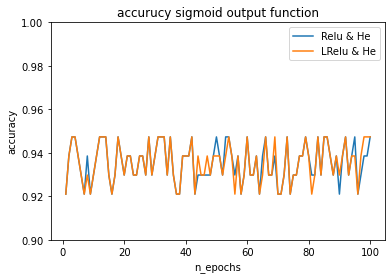

In [106]:
#plt.plot(n_epochs, acc_sig_he_sig, label='sigmoid & He')
#plt.plot(n_epochs, acc_sig_xav_sig, label='Sigmoid & Xav')
#plt.plot(n_epochs, acc_tanh_he_sig, label='tanh & He')
#plt.plot(n_epochs, acc_tanh_xav_sig, label='tanh & Xav')
plt.plot(n_epochs,acc_Rel_he_sig, label='Relu & He')
#plt.plot(n_epochs, acc_Rel_xav_sig, label='Relu & Xav')
plt.plot(n_epochs, acc_LRel_he_sig, label='LRelu & He')
#plt.plot(n_epochs, acc_LRel_xav_sig, label='LRelu & Xav')
plt.legend()
plt.xlabel("n_epochs")
plt.ylabel("accuracy")

plt.ylim(0.9,1)
plt.title("accurucy sigmoid output function")
plt.show()



In [93]:
print(acc_sig_xav_sig.mean())
print(acc_sig_he_sig.mean())

0.6897368421052632
0.9187719298245611


In [94]:
print(acc_tanh_xav_sig.mean())
print(acc_tanh_he_sig.mean())

0.7985964912280701
0.8425438596491226


In [95]:
print(acc_Rel_xav_sig.mean())
print(acc_Rel_he_sig.mean())
print(np.argmax(acc_Rel_he_sig))

0.900877192982456
0.9355263157894735
2


In [96]:
print(acc_LRel_xav_sig.mean())
print(acc_LRel_he_sig.mean())
print(np.argmax(acc_LRel_he_sig))

0.9014035087719298
0.9355263157894735
2


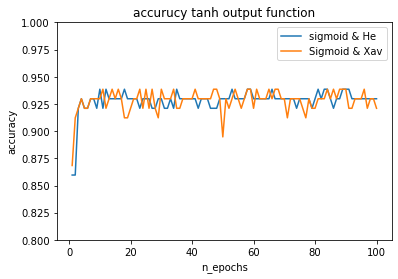

In [116]:
plt.plot(n_epochs, acc_sig_he_tanh, label='sigmoid & He')
plt.plot(n_epochs, acc_sig_xav_tanh, label='Sigmoid & Xav')
#plt.plot(n_epochs, acc_tanh_he_tanh, label='tanh & He')
#plt.plot(n_epochs, acc_tanh_xav_tanh, label='tanh & Xav')
#plt.plot(n_epochs,acc_Rel_he_tanh, label='Relu & He')
#plt.plot(n_epochs, acc_Rel_xav_tanh, label='Relu & Xav')
#plt.plot(n_epochs, acc_LRel_he_tanh, label='LRelu & He')
#plt.plot(n_epochs, acc_LRel_xav_tanh, label='LRelu & Xav')
plt.legend()
plt.xlabel("n_epochs")
plt.ylabel("accuracy")
plt.ylim(0.8,1)
plt.title("accurucy tanh output function")
plt.show()


In [107]:
print(acc_sig_xav_tanh.mean())
print(acc_sig_he_tanh.mean())
print(np.argmax(acc_sig_he_tanh))

0.928157894736842
0.9280701754385965
9


In [113]:
print(acc_tanh_xav_tanh.mean())
print(acc_tanh_he_tanh.mean())
print(np.argmax(acc_tanh_he_tanh))

0.8414912280701753
0.8988596491228068
46


In [114]:
print(acc_Rel_xav_tanh.mean())
print(acc_Rel_he_tanh.mean())
print(np.argmax(acc_Rel_he_tanh))

0.9237719298245612
0.9242105263157895
30


In [115]:
print(acc_LRel_xav_tanh.mean())
print(acc_LRel_he_tanh.mean())
print(np.argmax(acc_LRel_he_tanh))

0.9237719298245612
0.9245614035087719
30


# Comparing now with scikit 

Since Sigmoid underperformed the comparison will be between tanh and Relu of our own network vs that of scikit. 

In [102]:
from sklearn.neural_network import MLPClassifier

In [103]:

sickit_tanh_score=[]
sickit_Rel_score = []
for i in range(len(n_epochs)):
    epoch = n_epochs[i]
    regr_tanh = MLPClassifier(random_state=1,alpha = lmb_tanh_he_sig,activation="tanh",batch_size=batch_size, max_iter=epoch,learning_rate_init=eta_tanh_he_sig,solver="sgd").fit(X_train, z_train)
    regr_tanh.predict(X_test)
    
    regr_Relu = MLPClassifier(random_state=1,alpha = lmb_Rel_he_sig,activation="relu",batch_size=batch_size, max_iter=epoch,learning_rate_init=eta_Rel_xav_sig,solver ="sgd").fit(X_train, z_train)
    regr_Relu.predict(X_test)
    
    sickit_tanh_score.append(regr_tanh.score(X_test,z_test))
    sickit_Rel_score.append(regr_Relu.score(X_test,z_test))




C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_pe

C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilaye

C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (37) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (37) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilaye

C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (55) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (55) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (56) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (56) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilaye

C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (73) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (73) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (74) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (74) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilaye

C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (91) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (91) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (92) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (92) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilaye

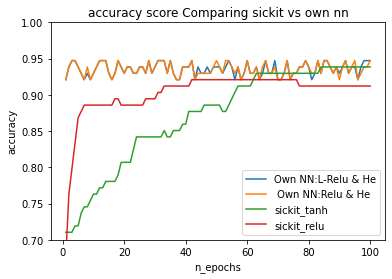

In [118]:
#plt.plot(n_epochs, r2_sig_he, label='sigmoid & He')
plt.plot(n_epochs, acc_LRel_he_sig, label='Own NN:L-Relu & He')
plt.plot(n_epochs, acc_Rel_he_sig, label=' Own NN:Relu & He')
#plt.plot(n_epochs, r2_tanh_he, label='own,tanh & He')
plt.plot(n_epochs, sickit_tanh_score, label='sickit_tanh')
plt.plot(n_epochs, sickit_Rel_score, label='sickit_relu')
#plt.plot(n_epochs, r2_Rel_he, label='own Relu & He')
#plt.plot(n_epochs, r2_LRel_he, label='LRelu & He')
#plt.plot(n_epochs, r2_LRel_xav, label='LRelu & Xav')
plt.legend()
plt.xlabel("n_epochs")
plt.ylabel("accuracy")
plt.ylim(0.7,1)
plt.title("accuracy score Comparing sickit vs own nn")
plt.show()

